<h2>1. import libraries</h2>

In [ ]:
#!pip install vaderSentiment
#nltk.download('stopwords')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.8 MB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import emoji

import re
plt.style.use('ggplot')

import nltk
from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

<h2>2. Read data</h2>

In [ ]:
df = pd.read_csv('clean_comments.csv')

In [ ]:
df

,Unnamed: 0,hotel_name,user_name,info_contr,comment_rank,comment_title,comment_text
0,0,Riad Shajara,Samuele L,"['Edinburgh, United Kingdom', '2 contributions']",5.0,A gem in the heart of the Medina,A newly renovated riad at ten minutes from Jem...
1,1,Riad Shajara,mattparker74,"['Dawlish, United Kingdom', '5 contributions',...",5.0,"Beautiful Islamic architecture, great location.",Shajara is a beautifully newly renovated prope...
2,2,Sol Oasis Marrakech,Tom R,NaN,5.0,Just go!,Sol oasis one of the best resort holidays we’v...
3,3,Sol Oasis Marrakech,Anton D,NaN,5.0,Best holiday ever,The rooms were nice and clean! Food was deligh...
4,4,Sol Oasis Marrakech,dinamaisuria1@gmail.com,"['2 contributions', '1 helpful vote']",5.0,Hotel and activities review,Just to say we have had the best time at the h...
...,...,...,...,...,...,...,...
12161,12723,Les Deux Tours,charlotte w,"['Heathfield, United Kingdom', '2 contribution...",5.0,Absolutely wonderful,We have just returned from Les Deux Tours and ...
12162,12724,Les Deux Tours,ExPatPete30,"['11 contributions', '5 helpful votes']",5.0,"Paradise. No, really, it is!",We stayed for 3 nights--I wish we'd stayed lon...
12163,12725,Les Deux Tours,Zoe M,"['London, England, United Kingdom', '2 contrib...",4.0,Pure relaxation outside the madness of the Medina,"From the moment we arrived at Les Deux Tours, ..."
12164,12726,Les Deux Tours,Jules M,"['Old Down, United Kingdom', '38 contributions...",4.0,Almost perfect but...,A fabulous oasis of peace 20 mins outside the ...


<h2>3. Exploratory Data analysis</h2>

<AxesSubplot:title={'center':'count of reviews by stars'}>

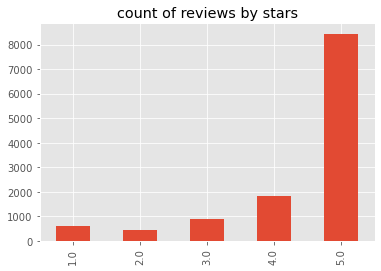

In [ ]:
#EDA
df['comment_rank'].value_counts().sort_index().plot(kind='bar', title='count of reviews by stars')


<h2>4. Comments pre-processing</h2

In [ ]:
stop = stopwords.words('english')

def comment_preprocess(text):
    

    r = text.lower()
    r=emoji.replace_emoji(r, replace="")
    r = re.sub("'", "", r)  #C'est pour éviter de supprimer les contractions en anglais
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = r.split()
    
    r = [w for w in r if not w in stop]
    r = " ".join(word for word in r)
    return r

<h2>5. VADER sentiments scoring</h2>

we will use sentimentIntensityAnalyser to get neg/pos/neu scores of the text<br>
this approach use <br>
1. stop words and removed
2. each word is scored and combined to a total score

In [ ]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


**Run the vader on the entire dataset**

In [ ]:
res=[]

    
for i,row in tqdm(df.iterrows(), total=len(df)):
    
    temp ={}
    temp["id"]=i
    temp["hotel_name"]=row['hotel_name']
    
    
    rank =row['comment_rank']
    temp["rank"]=rank
    temp['comment_text']=row['comment_text']
    
    
    text= row['comment_title'] +' '+row['comment_text']
    text =comment_preprocess(text)
    temp["score"]=sia.polarity_scores(text)
    res.append(temp)
    
scor1=pd.DataFrame(res).set_index('id')

  0%|          | 0/12166 [00:00<?, ?it/s]

In [ ]:

res=[]
for i in scor1['score']:
    res.append(i)

d = pd.DataFrame(res)
f=pd.concat([scor1, d], axis=1)
f=f.drop('score', axis=1)
f

,hotel_name,rank,comment_text,neg,neu,pos,compound
0,Riad Shajara,5.0,A newly renovated riad at ten minutes from Jem...,0.000,0.587,0.413,0.9904
1,Riad Shajara,5.0,Shajara is a beautifully newly renovated prope...,0.000,0.591,0.409,0.9804
2,Sol Oasis Marrakech,5.0,Sol oasis one of the best resort holidays we’v...,0.031,0.291,0.679,0.9866
3,Sol Oasis Marrakech,5.0,The rooms were nice and clean! Food was deligh...,0.000,0.211,0.789,0.9934
4,Sol Oasis Marrakech,5.0,Just to say we have had the best time at the h...,0.000,0.592,0.408,0.9891
...,...,...,...,...,...,...,...
12161,Les Deux Tours,5.0,We have just returned from Les Deux Tours and ...,0.020,0.619,0.361,0.9886
12162,Les Deux Tours,5.0,We stayed for 3 nights--I wish we'd stayed lon...,0.000,0.529,0.471,0.9944
12163,Les Deux Tours,4.0,"From the moment we arrived at Les Deux Tours, ...",0.096,0.603,0.301,0.9626
12164,Les Deux Tours,4.0,A fabulous oasis of peace 20 mins outside the ...,0.108,0.481,0.410,0.9880


<h2> 6. Results vizualization</h2>

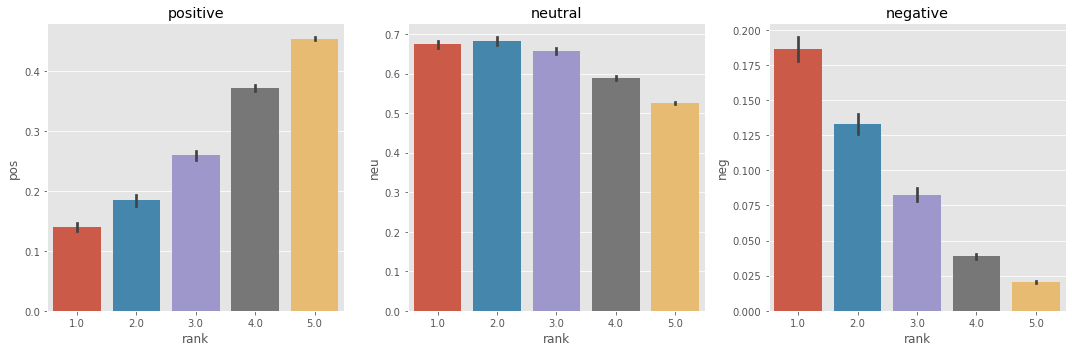

In [ ]:
fig, axs =plt.subplots(1,3, figsize=(15,5))

sns.barplot(data=e, x='rank',y='pos', ax=axs[0])
sns.barplot(data=e, x='rank',y='neu', ax=axs[1])
sns.barplot(data=e, x='rank',y='neg',ax=axs[2])

axs[0].set_title('positive')
axs[1].set_title('neutral')
axs[2].set_title('negative')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'negative Score Review')

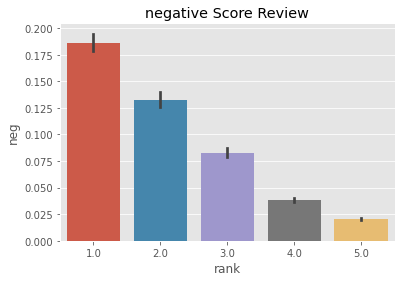

In [ ]:
ax = sns.barplot(data=e, x='rank',y='neg')
ax.set_title('negative Score Review')

Text(0.5, 1.0, 'compund Score Review')

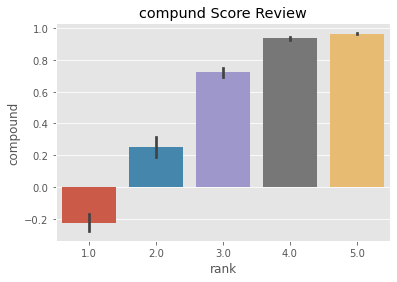

In [ ]:
ax = sns.barplot(data=e, x='rank',y='compound')
ax.set_title('compund Score Review')

<h2>7. Roberta model</h2>

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
sample=df['comment_text'][0]

In [ ]:
def polarity_roberta(text):

  encoded_text = tokenizer(text, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict= {
      'roberta_neg': scores[0],
      'roberta_neu': scores[1],
      'roberta_pos': scores[2]

  }
  return scores_dict

In [ ]:

res=[]
    
for i,row in tqdm(df.iterrows(), total=len(df)):
    
    temp ={}
    temp["id"]=i
    temp["hotel_name"]=row['hotel_name']
    
    
    rank =row['comment_rank']
    temp["rank"]=rank
    temp['comment_text']=row['comment_text']
    
    
    text= row['comment_title'] +' '+row['comment_text']
    text =comment_preprocess(text)
    temp["score"]=polarity_roberta(text)
    res.append(temp)
    
scor=pd.DataFrame(res).set_index('id')

  0%|          | 0/12166 [00:00<?, ?it/s]

In [ ]:
scor

,hotel_name,rank,comment_text,score
id,,,,
0,Riad Shajara,5.0,A newly renovated riad at ten minutes from Jem...,"{'roberta_neg': 0.002692991, 'roberta_neu': 0...."
1,Riad Shajara,5.0,Shajara is a beautifully newly renovated prope...,"{'roberta_neg': 0.0019156997, 'roberta_neu': 0..."
2,Sol Oasis Marrakech,5.0,Sol oasis one of the best resort holidays we’v...,"{'roberta_neg': 0.0022611804, 'roberta_neu': 0..."
3,Sol Oasis Marrakech,5.0,The rooms were nice and clean! Food was deligh...,"{'roberta_neg': 0.0017982386, 'roberta_neu': 0..."
4,Sol Oasis Marrakech,5.0,Just to say we have had the best time at the h...,"{'roberta_neg': 0.0031527071, 'roberta_neu': 0..."
...,...,...,...,...
12161,Les Deux Tours,5.0,We have just returned from Les Deux Tours and ...,"{'roberta_neg': 0.0020771683, 'roberta_neu': 0..."
12162,Les Deux Tours,5.0,We stayed for 3 nights--I wish we'd stayed lon...,"{'roberta_neg': 0.002924303, 'roberta_neu': 0...."
12163,Les Deux Tours,4.0,"From the moment we arrived at Les Deux Tours, ...","{'roberta_neg': 0.01944594, 'roberta_neu': 0.2..."


In [ ]:
res=[]
for i in scor['score']:
    res.append(i)

d = pd.DataFrame(res)
e=pd.concat([scor, d], axis=1)
e=e.drop('score', axis=1)
e

,hotel_name,rank,comment_text,roberta_neg,roberta_neu,roberta_pos
0,Riad Shajara,5.0,A newly renovated riad at ten minutes from Jem...,0.002693,0.030982,0.966325
1,Riad Shajara,5.0,Shajara is a beautifully newly renovated prope...,0.001916,0.020705,0.977379
2,Sol Oasis Marrakech,5.0,Sol oasis one of the best resort holidays we’v...,0.002261,0.014162,0.983577
3,Sol Oasis Marrakech,5.0,The rooms were nice and clean! Food was deligh...,0.001798,0.010054,0.988148
4,Sol Oasis Marrakech,5.0,Just to say we have had the best time at the h...,0.003153,0.060099,0.936748
...,...,...,...,...,...,...
12161,Les Deux Tours,5.0,We have just returned from Les Deux Tours and ...,0.002077,0.016274,0.981648
12162,Les Deux Tours,5.0,We stayed for 3 nights--I wish we'd stayed lon...,0.002924,0.030158,0.966918
12163,Les Deux Tours,4.0,"From the moment we arrived at Les Deux Tours, ...",0.019446,0.287852,0.692702
12164,Les Deux Tours,4.0,A fabulous oasis of peace 20 mins outside the ...,0.008581,0.033968,0.957451


In [ ]:
# g=pd.concat([f, e], axis=1)
g =f.merge(e, how='left')

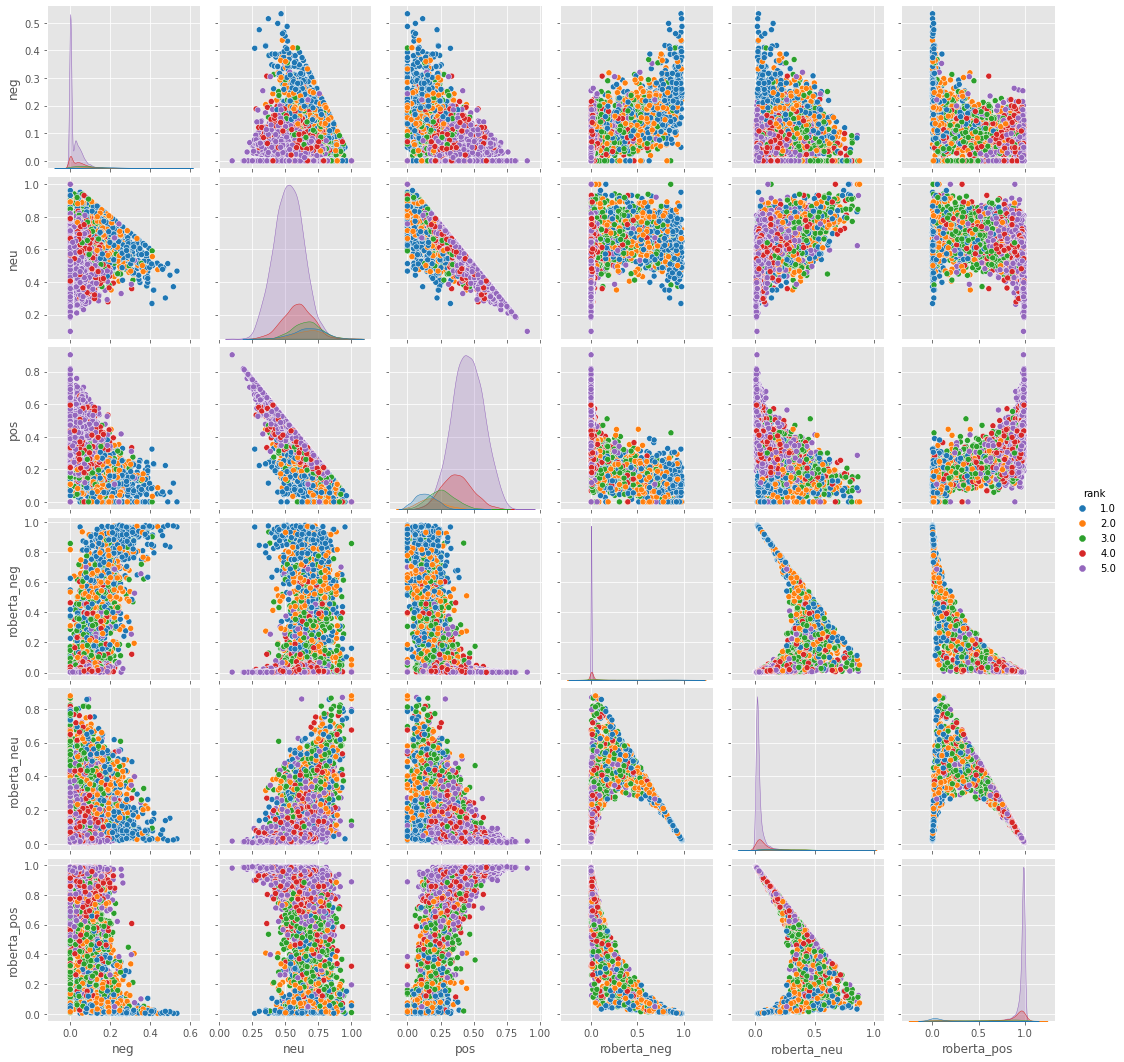

In [ ]:
sns.pairplot(data=g,vars=['neg', 'neu', 'pos',
                          'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue ='rank',
             palette= 'tab10'
             )
plt.show()

As we can see in the figure above Roberta is more precise than vader, and for the interval of different results are slightly different between them.

In [5]:
data = pd.read_csv('combined.csv')
data

,Unnamed: 0,hotel_name,rank,comment_text,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,0,Riad Shajara,5.0,A newly renovated riad at ten minutes from Jem...,0.000,0.587,0.413,0.9904,0.002693,0.030982,0.966325
1,1,Riad Shajara,5.0,Shajara is a beautifully newly renovated prope...,0.000,0.591,0.409,0.9804,0.001916,0.020705,0.977379
2,2,Sol Oasis Marrakech,5.0,Sol oasis one of the best resort holidays we’v...,0.031,0.291,0.679,0.9866,0.002261,0.014162,0.983577
3,3,Sol Oasis Marrakech,5.0,The rooms were nice and clean! Food was deligh...,0.000,0.211,0.789,0.9934,0.001798,0.010054,0.988148
4,4,Sol Oasis Marrakech,5.0,Just to say we have had the best time at the h...,0.000,0.592,0.408,0.9891,0.003153,0.060099,0.936748
...,...,...,...,...,...,...,...,...,...,...,...
12165,12165,Les Deux Tours,5.0,We have just returned from Les Deux Tours and ...,0.020,0.619,0.361,0.9886,0.002077,0.016274,0.981648
12166,12166,Les Deux Tours,5.0,We stayed for 3 nights--I wish we'd stayed lon...,0.000,0.529,0.471,0.9944,0.002924,0.030158,0.966918
12167,12167,Les Deux Tours,4.0,"From the moment we arrived at Les Deux Tours, ...",0.096,0.603,0.301,0.9626,0.019446,0.287852,0.692702
12168,12168,Les Deux Tours,4.0,A fabulous oasis of peace 20 mins outside the ...,0.108,0.481,0.410,0.9880,0.008581,0.033968,0.957451


In [7]:
#data.query('rank==2.0').sort_values('roberta_pos', ascending =True)

,Unnamed: 0,hotel_name,rank,comment_text,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
3689,3689,Labranda Rose Aqua Parc,2.0,Dirty rooms unfriendly unprofessional staff Di...,0.437,0.476,0.087,-0.9100,0.967399,0.030150,0.002451
760,760,Aqua Mirage Marrakech Hotel Club,2.0,Photos are not like the photos on here or the ...,0.219,0.725,0.056,-0.9325,0.972206,0.025220,0.002574
10160,10160,Mogador Hotels & Resorts,2.0,One of the worse places the frant disc staff a...,0.333,0.667,0.000,-0.9101,0.970311,0.026991,0.002697
740,740,Aqua Mirage Marrakech Hotel Club,2.0,"As mentioned below, (especially evenings) basi...",0.197,0.737,0.066,-0.8844,0.948380,0.048455,0.003165
2087,2087,Kenzi Club Agdal Medina,2.0,"this place is very mid. Personally, I didn't e...",0.284,0.629,0.087,-0.6836,0.965388,0.031445,0.003168
...,...,...,...,...,...,...,...,...,...,...,...
2050,2050,Kenzi Club Agdal Medina,2.0,This is a hard hotel to review to be honest. T...,0.039,0.428,0.533,0.9955,0.004606,0.041427,0.953967
9624,9624,Palais Sebban,2.0,We had mixed feelings about the Riad during ou...,0.065,0.608,0.326,0.9823,0.005669,0.039024,0.955307
9018,9018,Palais Khum,2.0,Palais Khum was highly recommended by Audley T...,0.000,0.642,0.358,0.9826,0.002658,0.037780,0.959563
9508,9508,2Ciels Luxury Boutique Hotel & Spa,2.0,I love this place so much and I want to come b...,0.000,0.485,0.515,0.9648,0.002467,0.019679,0.977854
